In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import math
import random
import matplotlib.animation as animation

from IPython.display import HTML


# Dynamic of the simple Inverted Linear Pendulum

This notebook presents an investigation into the dynamic of a simple linear inverted pendulum.

## Linear Inverted Pendulum Model

We investigate a simple model of an inverted pendulum as shown below. 

There is a point mass *m*, that rotates around a friction less pivot point, located at the origin.

The radius of the motion is *l*.

The angle between the line from the pivot point *O* to the mass *P* is *θ*.

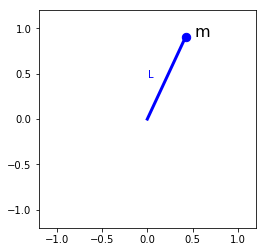

In [3]:
def calcPositionOfMass( state, l, origin = [ 0.0, 0.0 ] ):
    theta,_,_ = state
    ox, oy = origin
    px,py = ox + l * math.cos( math.pi / 2.0 - theta ), oy + l * math.sin( math.pi / 2.0 - theta )
    return np.array( [ px, py ] )

def drawRobot( ax, state, l, origin = [ 0.0, 0.0 ] ):
    theta, _, _ = state
    ox, oy = origin
    px,py = calcPositionOfMass( state, l, origin )
    line = np.array( [ [ ox, oy ], [ px, py ] ] ).T
    ax.plot( line[0,:], line[1,:], 'b-', linewidth=3.0 )
    ax.scatter( [px], [py], 70, 'b')
    ax.text( px + 0.1, py, 'm', fontsize=16)
    ax.text( 0.5 * px - 0.2, 0.5 * py, 'L', color='b')
    
fig = plt.figure()
ax = fig.add_subplot( 1, 1, 1 )
ax.set_aspect('equal')
ax.set_xlim( (-1.2, 1.2 ) )
ax.set_ylim( (-1.2, 1.2 ) )

origin = [ 0.0, 0.0 ]
initial = [ 25.0/180.0 * math.pi, 0.0/180.0 * math.pi, 0.0/180.0 * math.pi ]
L = 1.0 # m
M = 5.0 # kg
G = -9.81 # m/s**2

drawRobot( ax, initial, L )

## Dynamics of the Simple Inverted Pendulum

In the following I will analyze the forces acting on the simple inverted pendulum. There are several ways to derive the equations of motions. I will derive the equatiosn of motions using the forces directly, but you can derive the same result using the angular momentum and torque.

Let us analyze the forces acting on the simple inverted pendulum. 

In the following, it is important to realize that the angle *theta* is given in **radians**.

Since the pivot point is not actuated and is assumed to be frictionless, the only force acting on the mass is gravity.

The force acting on the point mass *m* is *F=m a*.

The part of *G* acting perpendicular to the motion is *F_perp = - m  g  sin( θ )*, so *a = - g  sin( θ )*

The part of *G* acting parallel to the link is *F_par = m  g  cos( θ )*

0.422618261741 0.906307787037 0.422618261741 0.415807787037


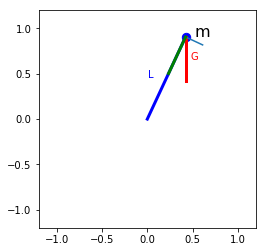

In [4]:
def drawForces( ax, state, l, origin = [ 0.0, 0.0 ], GScale = 20.0 ):
    theta, _, _ = state
    ox, oy = origin
    pos = calcPositionOfMass( state, l, origin )
    px, py = pos

    gx, gy = pos + [ 0.0, G/GScale ]
    print( px, py, gx, gy )
    ax.plot( [ px, gx ], [ py, gy ], 'r-', linewidth=3.0 )
    glx, gly = pos + [ 0.0, 0.5 * ( G / GScale ) ]
    ax.text( glx + 0.05, gly, 'G', color='red' )
    
    # Draw G components
    gPerp = G * math.sin( theta )
    gPerpX, gPerpY = pos + [ math.cos( math.pi - theta ) * gPerp / GScale, math.sin( math.pi - theta ) * gPerp / GScale ]
    ax.plot( [ px, gPerpX ], [ py, gPerpY ] )
    gPar = math.cos( theta ) * G
    gParX, gParY = pos - [ math.cos( - math.pi/2.0 - theta ) * gPar / GScale, 
                           math.sin( - math.pi/2.0 - theta ) * gPar / GScale ]
    ax.plot( [ px, gParX ], [ py, gParY ], 'g-', linewidth=3.0 )

fig = plt.figure()
ax = fig.add_subplot( 1, 1, 1 )
ax.set_aspect('equal')
ax.set_xlim( (-1.2, 1.2 ) )
ax.set_ylim( (-1.2, 1.2 ) )

drawRobot( ax, initial, L )
drawForces( ax, initial, L )

Now let relate that force *F_perp* to the change in the angle *θ*.

(2.1) Position *s* of the point mass *m* is:  $$s=l \frac{dθ}{dt}$$.

(2.2) Velocity $$v = \frac{ds}{dt} = l \frac{dθ}{dt}$$.

(2.3) Acceleration $$a = \frac{ds^2}{dt^2} = l \frac{d^2 θ}{dt^2}$$.

So we can combine Eq1 and Eq 2.3
$$ \frac{d^2θ}{dt^2} + \frac{g}{l} sin θ = 0$$

## Solving the Differential Equation

We cannot find the solution to this 2nd order differential equation analytically. 

However, by making the simplifying assumption that for small angles *θ*, that is *θ << 1*, then *sin θ = θ*, then we can find the analytical solution. The solution is a harmonic function with a period of $$\omega = 2 \pi \sqrt{ \frac{g}{l}}$$

## Solving the Differential Equation Numerically

Here, we are focusing on calculating the numerical solution for this differential equation. 

We simply approximate the integral by small piecewise projection of the function. So given an initial state *initial = [ θ, 0.0, 0.0 ], we can calculate the angular acceleration.

You may also use your favorite ODE solver and convert this into a matrix equation.

In [5]:
initial = [ 20.0/180.0 * math.pi, 0.0, 0.0 ]

def integrate( state, l, dt ):
    theta, theta_d, theta_dd = state
    theta = theta + theta_d * dt
    theta_d = theta_d + theta_dd * dt
    theta_dd = - G/l * math.sin(theta)
    return ( theta, theta_d, theta_dd )


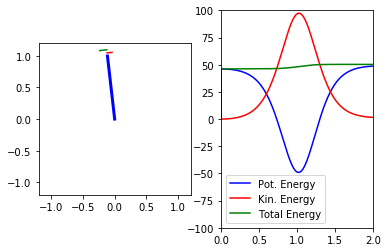

In [6]:
def updateAnimation( frame, lines, l, m, origin ):
    global state, EData
    pLine, vLine, aLine, ePotLine, eKinLine, eTotalLine = lines
    
    state = integrate( state, l, 0.01 )
    theta, theta_d, theta_dd = state
    pos = np.array( calcPositionOfMass( state, l, origin ) )
    pLine.set_data( [ origin[0], pos[0] ], [ origin[1], pos[1] ] )
    vel = np.array( [ math.cos( math.pi - theta ) * theta_d / 10, math.sin( math.pi - theta ) * theta_d / 10 ] )
    evStart = origin + 1.05 * ( pos - origin )
    evEnd = evStart - vel
    #print( pos, vel, ev )
    vLine.set_data( [ evStart[0], evEnd[ 0 ] ], [ evStart[1], evEnd[ 1 ] ] ) 

    eaStart = origin + 1.10 * ( pos - origin )
    accel = np.array( [ math.cos( math.pi - theta ) * theta_dd / 10, math.sin( math.pi - theta ) * theta_dd / 10 ] )
    eaEnd = eaStart - accel
    aLine.set_data( [ eaStart[0], eaEnd[ 0 ] ], [ eaStart[1], eaEnd[ 1 ] ] ) 

    ePot = - m * G * l * math.sin( math.pi / 2.0 - theta )
    eKin = 0.5 * m * l * theta_d ** 2
    eTotal = ePot + eKin
    #print('Energies', ePot, eKin, eTotal )

    EData = np.vstack( ( EData, np.array( ( frame * 0.01, ePot, eKin, eTotal ) ).T ) )
    ePotLine.set_data( EData[ :, 0 ], EData[ :, 1 ] )
    
    eKinLine.set_data( EData[ :, 0 ], EData[ :, 2 ] )
    
    #print( 'Lines', EData[0:20,0], EData[0:20,1] )
    #print(eTotalLine, EData.shape)
    eTotalLine.set_data( EData[ :, 0 ], EData[ :, 3 ] )
    
    ax.set_xlim( ( min(EData[:, 0] ) - 0.1, max( EData[:,0] ) + 0.1 ) )
    
fig = plt.figure()
ax1 = fig.add_subplot( 1, 2, 1 )
ax1.set_aspect('equal')
ax1.set_xlim( (-1.2, 1.2 ) )
ax1.set_ylim( (-1.2, 1.2 ) )

pLine, = ax1.plot( [], [], 'b-', linewidth=3.0 )
vLine, = ax1.plot( [], [], 'r-' )
aLine, = ax1.plot( [], [], 'g-' )

ax2 = fig.add_subplot( 1, 2, 2 )
ax2.set_xlim( ( 0, 2 ) )
ax2.set_ylim( ( -100, 100 ) )

ePotLine, = ax2.plot( [0], [0], 'b-', label = 'Pot. Energy' )
eKinLine, = ax2.plot( [0], [0], 'r-', label = 'Kin. Energy' )
eTotalLine, = ax2.plot( [0], [0], 'g-', label = 'Total Energy' )

ax2.legend()

def setupAnimation( ):
    global state, EData
    EData = np.empty( ( 4, ) ).T
    state = initial

lineAni = animation.FuncAnimation(fig, updateAnimation, 200, fargs=( [ pLine, vLine, aLine, ePotLine, eKinLine, eTotalLine ], L, M, origin ),
                                   interval=50, blit=False, init_func = setupAnimation )
HTML(lineAni.to_html5_video())
#print(EData)

# Compass Walker

In this section, I extend the linear inverted pendulum model to a compass walker. The compass walker has two legs where each leg is a linear inverted pendulum. This is a simplification of our passive dynamic walker.

The state of the robot consists of the dynamics of each leg (thetaL, thetaL_d, thetaL_dd) and (thetaR, thetaR_d, thetaR_dd).

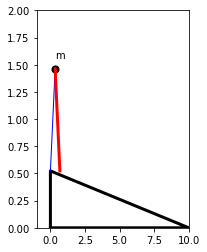

In [28]:
def drawEnvironment( ax, length, alpha ):
    height = math.sin( alpha ) * length
    ax.plot( [ 0, length, 0, 0 ], [ 0, 0, height, 0], 'k-', linewidth = 3.0 )

def drawRobot( ax, state ):
    posx, posy, support, legLength, leftLeg, rightLeg = state
    thetaL, _, _ = leftLeg
    thetaR, _, _ = rightLeg
    
    if ( support == 'left '):
        lwL = 3.0
        lwR = 1.0
    else:
        lwL = 1.0
        lwR = 3.0

    aLx, aLy = posx - math.sin( thetaL ) * legLength, posy - math.cos( thetaL ) * legLength
    
    ax.plot( [posx, aLx], [posy, aLy ], 'b-', linewidth = lwL )

    aRx, aRy = posx - math.sin( thetaR ) * legLength, posy - math.cos( thetaR ) * legLength
    ax.plot( [ posx, aRx], [ posy, aRy ], 'r-', linewidth = lwR )
    
    ax.scatter( posx, posy, 50, color='black' )
    ax.text( posx, posy + 0.1, 'm' )

def calcRobotPosition( state, env ):
    rl, alpha = env
    _, _, support, legLength, left, right = state
    thetaL, _, _ = left
    thetaR, _, _ = right
    if ( support == 'left' ):
        posx, posy  = math.sin( thetaL ) * legLength, rl * math.sin( alpha ) + math.cos( thetaL ) * legLength
    else:
        posx, posy  = math.sin( thetaR ) * legLength, rl * math.sin( alpha ) + math.cos( thetaR ) * legLength
    state[0], state[1] = posx, posy
    return ( posx, posy )
    
RAMPLENGTH = 10.0
ALPHA = 3.0/180.0 * math.pi 

env = ( RAMPLENGTH, ALPHA )
LEGLENGTH = 1.0

fig = plt.figure()
ax1 = fig.add_subplot( 1, 2, 1 )
#ax1.set_aspect('equal')
ax1.set_xlim( (-1.0, RAMPLENGTH ) )
ax1.set_ylim( (0.0, 2.0 ) )

thetaL = 20.0/180.0 * math.pi
thetaR = -20.0/180.0 * math.pi

initial = [ 0.0, 0.0, 
         'left', 
         LEGLENGTH,
         [ thetaL, 0.0/180.0 * math.pi, 0.0/180.0 * math.pi ], 
         [ thetaR, 0.0/180.0 * math.pi, 0.0/180.0 * math.pi ] ]

state = initial
calcRobotPosition( state, env )

drawEnvironment( ax1, LENGTH, ALPHA )
drawRobot( ax1, state )